#Step 0: Problem Statement

Aim of this project is to detect Covid-19 from X-ray and also able to differentitate Covid-19 from viral pneumonia and bacterial pneumonia. I have created a custom dataset that contains covid-19 x-ray images, viral pneumonia x-ray images, bacterial pneumonia x-ray iamges and normal person x-ray images.Each class contains 133 images.

##Dataset Source
I have used data from 


*   https://github.com/ieee8023/covid-chestxray-dataset 
*   https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia




#Step 1: Importing necessary packages and getting the dataset:

In [57]:
%cd /content/drive/My Drive

/content/drive/My Drive


In [72]:
!git clone https://github.com/kukeshajanth/Covid-19_and_Pneumonia_X-Ray_Detector.git

Cloning into 'Covid-19_and_Pneumonia_X-Ray_Detector'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 590 (delta 1), reused 45 (delta 0), pack-reused 544
Receiving objects: 100% (590/590), 125.42 MiB | 13.38 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (573/573), done.


In [0]:
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from IPython.display import display
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [76]:
%cd /content/drive/My Drive/Covid-19_and_Pneumonia_X-Ray_Detector


/content/drive/My Drive/Covid-19_and_Pneumonia_X-Ray_Detector


In [0]:
import shutil

dir_path = 'Covid-19_and_Pneumonia_X-Ray_Detector'

try:
    shutil.rmtree(dir_path)
except OSError as e:
    print("Error: %s : %s" % (dir_path, e.strerror))

# Step 2: Setting up image generator

In [41]:
data_directory = "/content/drive/My Drive/Covid-19_and_Pneumonia_X-Ray_Detector/Dataset"
os.listdir(data_directory)

['0', '1', '2', '3']

In [0]:
image_generator = ImageDataGenerator(rescale = 1./255, fill_mode = 'nearest', validation_split= 0.2)

In [43]:
train_generator = image_generator.flow_from_directory(batch_size = 4, directory= data_directory, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset="training")

val_generator = image_generator.flow_from_directory(batch_size = 4, directory= data_directory, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset="validation")

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [44]:
images, label = next(train_generator)

images.shape

(4, 256, 256, 3)

In [45]:
np.argmax(label[0])

1

In [0]:
label_names = {0 : 'Covid-19', 1 : 'Normal' , 2: 'Viral Pneumonia', 3 : 'Bacterial Pneumonia'}

# Step 3: Visualizing

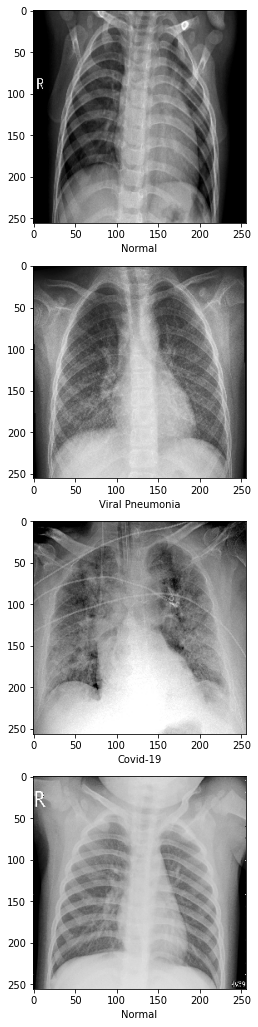

In [48]:
fig=plt.figure(figsize = (18,18))
for i in range(4):
    fig.add_subplot(4,1,i+1)
    plt.xlabel(label_names[np.argmax(label[i])])
    plt.imshow(images[i])
plt.show()


# Step 4 :Resnet- 18 Model

In [0]:
def res_block(X, filter, stage):
  #Convolutional_block

  X_copy = X

  f1 , f2, f3 = filter
  #Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)


  #Short path

  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  #ADD

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  #Identity Block 1

  X_copy = X


  #Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  #ADD

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  #Identity Block 2

  X_copy = X


  #Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  #ADD

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [64]:

input_shape = (256,256,3)

#Input tensor shape
X_input = Input(input_shape)

#Zero-padding

X = ZeroPadding2D((3,3))(X_input)

# 1 - stage

X = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

# 2- stage

X = res_block(X, filter= [64,64,256], stage= 2)

# 3- stage

X = res_block(X, filter= [128,128,512], stage= 3)

# 4- stage

X = res_block(X, filter= [256,256,1024], stage= 4)

# 5- stage

X = res_block(X, filter= [512,512,2048], stage= 5)

#Average Pooling

X = AveragePooling2D((2,2), name = 'Averagea_Pooling')(X)

#Final layer

X = Flatten()(X)
X = Dense(4, activation = 'softmax', name = 'Dense_final', kernel_initializer= glorot_uniform(seed=0))(X)


model = Model( inputs= X_input, outputs = X, name = 'Resnet18')
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics= ['accuracy'])
model.summary()

Model: "Resnet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_8 (ZeroPadding2D (None, 262, 262, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        zero_padding2d_8[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [0]:
#using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

#save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)

In [65]:
history = model.fit_generator(train_generator, steps_per_epoch= train_generator.n // 4, epochs = 50, validation_data= val_generator, validation_steps= val_generator.n // 4, callbacks=[checkpointer , earlystopping])

Epoch 1/50
107/107 [==============================] - ETA: 0s - loss: 84.6704 - accuracy: 0.5280
Epoch 00001: val_loss improved from inf to 3.62469, saving model to weights.hdf5
107/107 [==============================] - 83s 779ms/step - loss: 84.6704 - accuracy: 0.5280 - val_loss: 3.6247 - val_accuracy: 0.2212
Epoch 2/50
107/107 [==============================] - ETA: 0s - loss: 28.3777 - accuracy: 0.6332
Epoch 00002: val_loss did not improve from 3.62469
107/107 [==============================] - 80s 751ms/step - loss: 28.3777 - accuracy: 0.6332 - val_loss: 16.0457 - val_accuracy: 0.2596
Epoch 3/50
107/107 [==============================] - ETA: 0s - loss: 7.9739 - accuracy: 0.7336
Epoch 00003: val_loss improved from 3.62469 to 3.09060, saving model to weights.hdf5
107/107 [==============================] - 84s 782ms/step - loss: 7.9739 - accuracy: 0.7336 - val_loss: 3.0906 - val_accuracy: 0.6058
Epoch 4/50
107/107 [==============================] - ETA: 0s - loss: 5.2019 - accuracy:

In [0]:
#saving the model architecture to json file for future use

model_json = model.to_json()
with open("resnet-18.json","w") as json_file:
  json_file.write(model_json)

In [0]:
#loading the weights to the model

model.load_weights('weights.hdf5')

In [67]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

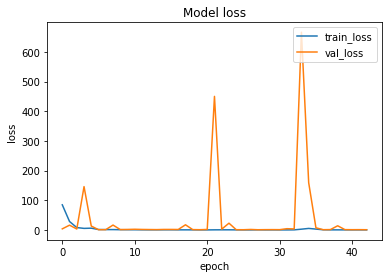

In [68]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'upper right')
plt.show()

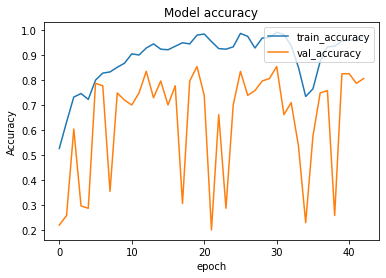

In [69]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy','val_accuracy'], loc = 'upper right')
plt.show()

# Step 5: Testing the model

In [0]:
test_directory = "/content/drive/My Drive/Covid-19_and_Pneumonia_X-Ray_Detector/Test"

In [78]:
test_gen = ImageDataGenerator(rescale = 1./255)

test_generator = test_gen.flow_from_directory(batch_size = 4, directory= test_directory, shuffle= True, target_size=(256,256), class_mode= 'categorical')

evaluate = model.evaluate_generator(test_generator, steps = test_generator.n // 4, verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

Found 40 images belonging to 4 classes.
Instructions for updating:
Please use Model.evaluate, which supports generators.
10/10 [==============================] - 2s 203ms/step - loss: 1.5822 - accuracy: 0.7000
Accuracy Test : 0.699999988079071


In [0]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory,str(i))):
    img= cv2.imread(os.path.join(test_directory,str(i),item))
    img = cv2.resize(img,(256,256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1,256,256,3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

In [135]:
score = accuracy_score(original,prediction)
print("Test Accuracy : {}".format(score))

Test Accuracy : 0.7


In [108]:
fig=plt.figure(figsize = (180,180))
for i in range(40):
    fig.add_subplot(40,1,i+1)
    plt.xlabel("Prediction -" + str(label_names[prediction[i]]) +"   Original -" + str(label_names[original[i]]))
    plt.imshow(image[i])
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [136]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80        10
           1       0.62      0.80      0.70        10
           2       0.75      0.60      0.67        10
           3       1.00      0.40      0.57        10

    accuracy                           0.70        40
   macro avg       0.76      0.70      0.68        40
weighted avg       0.76      0.70      0.68        40



Text(0.5, 1.0, 'Confusion_matrix')

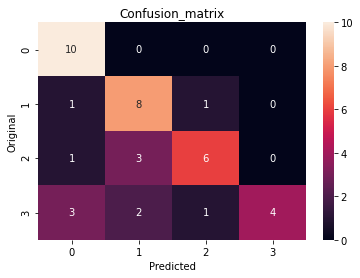

In [134]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')
